# Frozen lake : Reinforcement Learning
![ Frozen lake](images/frozen_lake.gif) 

For the first part of the project we will tackle the frozen lake Envirement which involves crossing a frozen lake from the start position to a predetermined goal without falling into any holes. The solution isn't deterministic as the player can slip on the ice.
 
## Envirement description : 

### 1. Action Space
The action shape is as follows : 
- 0: Move left
- 1: Move down
- 2: Move right
- 3: Move up

### 2. Observation Space
The observation is a value representing the player’s current position= and it ranges from 0 to the map's width*height-1.

### 3. Starting State
The episode starts with the player in state [0] at the location [0, 0] in the map.

### 4. Rewards : 
Reward can be defined as follows : 
- Reach goal: +1
- Reach hole: 0
- Reach frozen: 0

### 5. Episode End : 
The episode ends if the following happens:
- Termination:
    - The player moves into a hole.
    - The player reaches the goal at max(width) * max(height) - 1 (location [width-1, height-1]).
- Truncation :
    - The length of the episode is 100 for 4x4 environment, 200 for 8x8 environment.


Uploading the necessary libraries and modules needed for our experiment.

In [130]:
import gymnasium as gym
#from tools.qlearning import *
import numpy as np
import matplotlib.pyplot   as plt
import pandas as pd

We will experiment with both conditions `is_slippery=True` and `is_slippery=False`

In [191]:
# To speed up the process we will set the render_mode as None.
env = gym.make("FrozenLake-v1", is_slippery=True, render_mode=None)
np.random.seed(42)
observation, info = env.reset(seed=42)
num_actions = env.action_space.n
num_states = env.observation_space.n

# 1. Algorithms
### 1.1 Q-Learning

In [192]:
import numpy as np
from tqdm import *
def q_train(env, alpha=0.01, gamma=0.9, max_n_steps=100, n_episodes=10000, weights=None):
    """ Q-learning algorithm 
    
    """
    rewards =[]
    num_actions = env.action_space.n
    num_states = env.observation_space.n
    
    try :
        print("Loading Q-table saved weights...")
        q_table = np.load(weights)

    except :
        print("Error loading Q-table saved weights")
        print("Initiating new Q-table...")
        q_table = np.zeros((num_states, num_actions))

    print("Starting Q-learning algorithm...")
    for _ in trange(n_episodes):
        s = env.reset()[0]
        total_reward = 0
        for i in range(max_n_steps):
            a = np.argmax(q_table[s]) # Select action a given s (state) following policy derived from q;
            
            s_new, r, done, truncated , info = env.step(a) # Take action a and observe the reward and next state s_new and reward r
            #print(s, a, r, s_new, done)
            
            # Update Q-table
            q_table[s, a] = (1-alpha)*q_table[s, a] + alpha*(r + gamma*np.max(q_table[s_new]))
            
            # update state and total reward
            s = s_new
            total_reward = total_reward + r

            # if s is a terminal state then go to next episode;
            if done or truncated: 
                rewards.append(total_reward) 
                break
            
    env.close()
    print("Finished Q-learning algorithm.")
    print("Average reward is : {}".format(np.mean(rewards)))

    return q_table



In [193]:
q_table = q_train(env)

# q_table = q_train(env, weights="data/q_table.npy")
# np.save('data/q_table.npy', q_table)

Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:04<00:00, 2057.30it/s]

Finished Q-learning algorithm.
Average reward is : 0.0


### 1.2 Q-Learning ( $\epsilon-greedy$)

$\epsilon-greedy$ is an good strategy for balancing exploration and exploitation.

In [194]:
def q_train_greedy(env, alpha=0.99, gamma=0.9, epsilon=0.1, max_n_steps=100, n_episodes=10000, weights=None):
    """ Q-learning algorithm (epsilon-greedy)
    
    """
    num_actions = env.action_space.n
    num_states = env.observation_space.n
    
    try :
        print("Loading Q-table saved weights...")
        q_table = np.load(weights)

    except :
        print("Error loading Q-table saved weights")
        print("Initiating new Q-table...")
        q_table = np.zeros((num_states, num_actions))

    rewards = []

    print("Starting Q-learning algorithm...")
    for _ in trange(n_episodes):
        s = env.reset()[0]
        total_reward = 0
        for i in range(max_n_steps):
            U = np.random.uniform(0, 1)
            if U < epsilon:
                a = env.action_space.sample() # selecting action a at random from A 
            else:
                a = np.argmax(q_table[s]) # Select action a given s (state) following policy derived from q;
            
            s_new, r, done, _ , _= env.step(a)
            
            # Update Q-table
            q_table[s, a] = (1-alpha)*q_table[s, a] + alpha*(r + gamma*np.max(q_table[s_new]))
            
            # update state and total reward
            s, total_reward = s_new, total_reward+r

            # if s is a terminal state then go to next episode;
            if done: 
                rewards.append(total_reward) 
                break
    env.close()
    print("Finished Q-learning algorithm.")
    print("Average reward is : {}".format(np.mean(rewards)))
    return q_table

In [198]:
q_table_greedy = q_train_greedy(env)
# q_table_greedy = q_train_greedy(env,weights="data/q_table_greedy.npy")
# np.save('data/q_table_greedy.npy', q_table_greedy)

Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:05<00:00, 1781.93it/s]

Finished Q-learning algorithm.
Average reward is : 0.0830747672905615



### 1.3 Q-learning epsilon decay
The concept of decay : 
During the lifecycle of an agent that does not have sufficient information on its environment, exploration is more important than exploitation. Once the agent has enough information about the environment, we can then start to exploit that information to improve the agent's performance [Source](https://arxiv.org/pdf/1910.13701.pdf). That's why we'll use the concept of decay by starting with a maximum value of epsilon and then decaying it gradually across every episode. 



In [199]:

def q_train_greedy_decay(env, alpha=0.8, gamma=0.9,min_epsilon=0.005, decay_rate=0.001, max_n_steps=100, n_episodes=10000, weights=None):
    """ Q-learning algorithm (epsilon-greedy) with exponential epsilon decay
    
    """
    num_actions = env.action_space.n
    num_states = env.observation_space.n
    
    try :
        print("Loading Q-table saved weights...")
        q_table = np.load(weights)

    except :
        print("Error loading Q-table saved weights")
        print("Initiating new Q-table...")
        q_table = np.zeros((num_states, num_actions))

    rewards = []
    epsilon = 1
    
    print("Starting Q-learning algorithm...")
    for episode in trange(n_episodes):
        s = env.reset()[0]
        total_reward = 0
        for i in range(max_n_steps):
            U = np.random.uniform(0, 1)
            if U < epsilon:
                a = env.action_space.sample() # selecting action a at random from A 
            else:
                a = np.argmax(q_table[s]) # Select action a given s (state) following policy derived from q;
            
            s_new, r, done, _ , _= env.step(a)

            # Update Q-table
            q_table[s, a] = (1-alpha)*q_table[s, a] + alpha*(r + gamma*np.max(q_table[s_new]))
            
            # update state and total reward
            s, total_reward = s_new, total_reward+r

            # if s is a terminal state then go to next episode;
            if done: 
                # Epsilon exponential decay
                epsilon = min_epsilon + (1-min_epsilon)*np.exp(-decay_rate*episode)
                rewards.append(total_reward) 
                break
            
    env.close()
    print("Finished Q-learning algorithm.")
    print("Average reward is : {}".format(np.mean(rewards)))
    return q_table

In [200]:
q_table_greedy_decay=q_train_greedy_decay(env)
# q_table_greedy_decay=q_train_greedy_decay(env, weights="data/q_table_greedy_decay.npy")
# np.save("data/q_table_greedy_decay.npy", q_table_greedy)

Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:08<00:00, 1119.42it/s]

Finished Q-learning algorithm.
Average reward is : 0.347928872443211


### 1.4 SARSA

In [201]:
def sarsa_train(env, alpha=0.1, gamma=1, epsilon=0.5, episodes=10000, steps=1000) :

    num_actions = env.action_space.n
    num_states = env.observation_space.n
    q = np.zeros((num_states, num_actions))

    for ep in trange(episodes) : 
        
        env.reset()
        state = env.s

        
        if np.random.uniform() < epsilon :
            action = env.action_space.sample()
        else :
            action = np.argmax(q[state, :])
            
        for _ in range(steps) :
            nw_state, reward, terminated, truncated, info = env.step(action)
            
            if np.random.uniform() < epsilon :
                nw_action = env.action_space.sample()
            else :
                nw_action = np.argmax(q[nw_state, :])
                
            q[state, action] = (1-alpha)*q[state, action] + \
                alpha*(reward + gamma*q[nw_state, nw_action])
                
            state = nw_state
            action = nw_action
            
            if terminated or truncated :
                break
    
    env.close()
    
    return q

In [202]:
sarsa_table = sarsa_train(env, alpha = 0.1, gamma = 1, epsilon = 0.5, episodes = 10000, steps = 1000)

100%|██████████| 10000/10000 [00:03<00:00, 2922.94it/s]


In [203]:
def agent_play(env,q_table, max_n_episodes=10000, max_steps=100):
    count = 0
    rewards = []
    num_steps = []
    for _ in trange(max_n_episodes):
        s = env.reset()[0]
        total_reward = 0
        for i in range(max_steps):
            a = np.argmax(q_table[s])
            s, r, done, tr,_ = env.step(a)
            total_reward+=r
            if done or tr: 
                rewards.append(total_reward)
                num_steps.append(i+1)
                count+=1
                break
    success_rate = np.mean(rewards)
    avg_num_steps = np.mean(num_steps)
    print(f'Success rate is = {100*success_rate} %')
    print(f'Average number of steps to succeed is = {avg_num_steps}')
    return rewards, success_rate, avg_num_steps

In [204]:
rewards_d, success_rate_d, avg_num_steps_d= agent_play(env, q_table=deterministic_q_table)
rewards_q, success_rate_q, avg_num_steps_q= agent_play(env, q_table=q_table)
rewards_q_greedy, success_rate_q_greedy, avg_num_steps_q_greedy= agent_play(env, q_table=q_table_greedy)
rewards_q_greedy_decay, success_rate_q_greedy_decay, avg_num_steps_q_greedy_decay= agent_play(env, q_table=q_table_greedy_decay)
rewards_sarsa, success_rate_sarsa, avg_num_steps_sarsa= agent_play(env, q_table=sarsa_table)


100%|██████████| 10000/10000 [00:00<00:00, 10182.00it/s]


Success rate is = 4.44 %
Average number of steps to succeed is = 5.0499


100%|██████████| 10000/10000 [00:02<00:00, 3468.15it/s]


Success rate is = 0.0 %
Average number of steps to succeed is = 18.0148


100%|██████████| 10000/10000 [00:06<00:00, 1452.84it/s]


Success rate is = 55.52 %
Average number of steps to succeed is = 43.3423


100%|██████████| 10000/10000 [00:06<00:00, 1487.17it/s]


Success rate is = 72.72999999999999 %
Average number of steps to succeed is = 41.3862


100%|██████████| 10000/10000 [00:06<00:00, 1636.27it/s]

Success rate is = 67.16 %
Average number of steps to succeed is = 37.855


## 2. comparaison

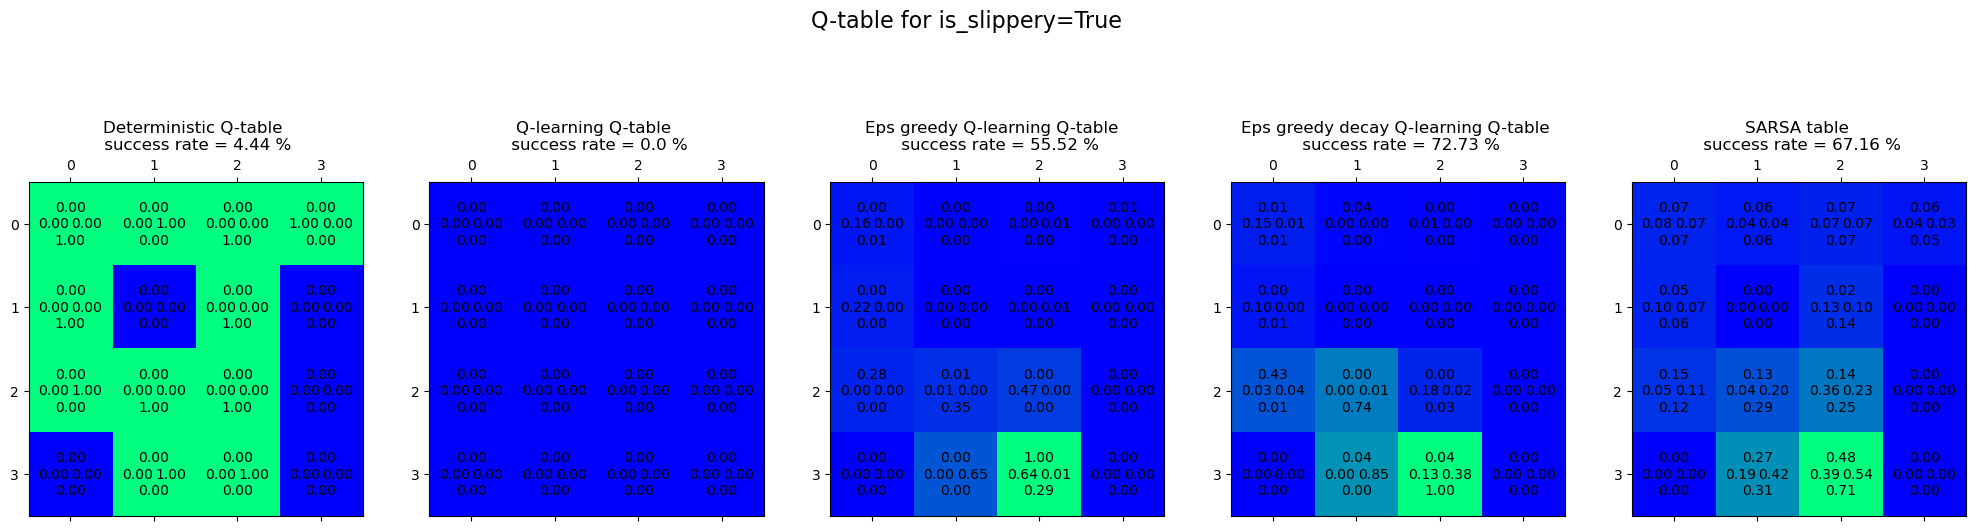

In [207]:
deterministic_q_table = np.load("data/deterministic_q_table.npy")

fig, ax = plt.subplots(1, 5)
fig.set_size_inches(25, 7)
# im = Image.open('images/frozen_lake.jpg')
fig.suptitle("Q-table for is_slippery=True", fontsize=16)

# Creating the heat maps
map_q = np.sum(q_table, axis = 1)
map_q= map_q.reshape(4, 4)

map_d = np.sum(deterministic_q_table, axis = 1)
map_d= map_d.reshape(4, 4)

map_g = np.sum(q_table_greedy, axis = 1)
map_g= map_g.reshape(4, 4)

map_e = np.sum(q_table_greedy_decay, axis = 1)
map_e= map_e.reshape(4, 4)

map_s = np.sum(sarsa_table, axis = 1)
map_s= map_s.reshape(4, 4)


# ax[0].imshow(im, alpha=1)
# ax[1].imshow(im, alpha=1)

ax[0].matshow(map_d, cmap='winter')
ax[1].matshow(map_q, cmap='winter')
ax[2].matshow(map_g, cmap='winter')
ax[3].matshow(map_e, cmap='winter')
ax[4].matshow(map_s, cmap='winter')

pos=[0,1,2,3]

deterministic_q_table_reshaped=deterministic_q_table.reshape((4,4,4))
q_table_reshaped=q_table.reshape((4,4,4))
greedy_reshaped=q_table_greedy.reshape((4,4,4))
q_table_greedy_decay_reshaped =q_table_greedy_decay.reshape((4,4,4))
sarsa_reshaped =sarsa_table.reshape((4,4,4))


deviation = 0.2
for i in pos: # rows
    for j in pos: # cols

        ax[0].text(j-deviation, i, '{:0.2f}'.format(deterministic_q_table_reshaped[i][j][0]), ha='center', va='center') # 0 Left
        ax[0].text(j, i+deviation, '{:0.2f}'.format(deterministic_q_table_reshaped[i][j][1]), ha='center', va='center') # 1 Down
        ax[0].text(j+deviation, i, '{:0.2f}'.format(deterministic_q_table_reshaped[i][j][2]), ha='center', va='center') # 2 right
        ax[0].text(j, i-deviation, '{:0.2f}'.format(deterministic_q_table_reshaped[i][j][3]), ha='center', va='center') # 3 up
        ax[0].set_title(f"Deterministic Q-table \n success rate = {round(100*success_rate_d,2)} %")

        ax[1].text(j-deviation, i, '{:0.2f}'.format(q_table_reshaped[i][j][0]), ha='center', va='center') # 0 Left
        ax[1].text(j, i+deviation, '{:0.2f}'.format(q_table_reshaped[i][j][1]), ha='center', va='center') # 1 Down
        ax[1].text(j+deviation, i, '{:0.2f}'.format(q_table_reshaped[i][j][2]), ha='center', va='center') # 2 right
        ax[1].text(j, i-deviation, '{:0.2f}'.format(q_table_reshaped[i][j][3]), ha='center', va='center') # 3 up
        ax[1].set_title(f"Q-learning Q-table \n success rate = {round(100*success_rate_q,2)} %")

        ax[2].text(j-deviation, i, '{:0.2f}'.format(greedy_reshaped[i][j][0]), ha='center', va='center') # 0 Left
        ax[2].text(j, i+deviation, '{:0.2f}'.format(greedy_reshaped[i][j][1]), ha='center', va='center') # 1 Down
        ax[2].text(j+deviation, i, '{:0.2f}'.format(greedy_reshaped[i][j][2]), ha='center', va='center') # 2 right
        ax[2].text(j, i-deviation, '{:0.2f}'.format(greedy_reshaped[i][j][3]), ha='center', va='center') # 3 up
        ax[2].set_title(f"Eps greedy Q-learning Q-table  \n success rate = {round(100*success_rate_q_greedy,2)} %")


        ax[3].text(j-deviation, i, '{:0.2f}'.format(q_table_greedy_decay_reshaped[i][j][0]), ha='center', va='center') # 0 Left
        ax[3].text(j, i+deviation, '{:0.2f}'.format(q_table_greedy_decay_reshaped[i][j][1]), ha='center', va='center') # 1 Down
        ax[3].text(j+deviation, i, '{:0.2f}'.format(q_table_greedy_decay_reshaped[i][j][2]), ha='center', va='center') # 2 right
        ax[3].text(j, i-deviation, '{:0.2f}'.format(q_table_greedy_decay_reshaped[i][j][3]), ha='center', va='center') # 3 up
        ax[3].set_title(f"Eps greedy decay Q-learning Q-table \n success rate = {round(100*success_rate_q_greedy_decay,2)} %")

        ax[4].text(j-deviation, i, '{:0.2f}'.format(sarsa_reshaped[i][j][0]), ha='center', va='center') # 0 Left
        ax[4].text(j, i+deviation, '{:0.2f}'.format(sarsa_reshaped[i][j][1]), ha='center', va='center') # 1 Down
        ax[4].text(j+deviation, i, '{:0.2f}'.format(sarsa_reshaped[i][j][2]), ha='center', va='center') # 2 right
        ax[4].text(j, i-deviation, '{:0.2f}'.format(sarsa_reshaped[i][j][3]), ha='center', va='center') # 3 up
        ax[4].set_title(f"SARSA table \n success rate = {round(100*success_rate_sarsa,2)} %")
plt.show()

Then we'll define a play function for our game to test the performance

/tmp/ipykernel_57852/995146866.py:2: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.arange(len(rewards_d)), np.cumsum(rewards_d)/np.arange(len(rewards_d)), label="Cumulative Average success rate for a deterministic policy")
/tmp/ipykernel_57852/995146866.py:3: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.arange(len(rewards_q)), np.cumsum(rewards_q)/np.arange(len(rewards_q)), label="Cumulative Average success rate for Q-learning")
/tmp/ipykernel_57852/995146866.py:4: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.arange(len(rewards_q_greedy)), np.cumsum(rewards_q_greedy)/np.arange(len(rewards_q_greedy)), label="Cumulative Average success rate for Q-learning epsilon Greedy")
/tmp/ipykernel_57852/995146866.py:5: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.arange(len(rewards_q_greedy_decay)), np.cumsum(rewards_q_greedy_decay)/np.arange(len(rewards_q_greedy_decay)), label="Cumulative Average success rate for Q-

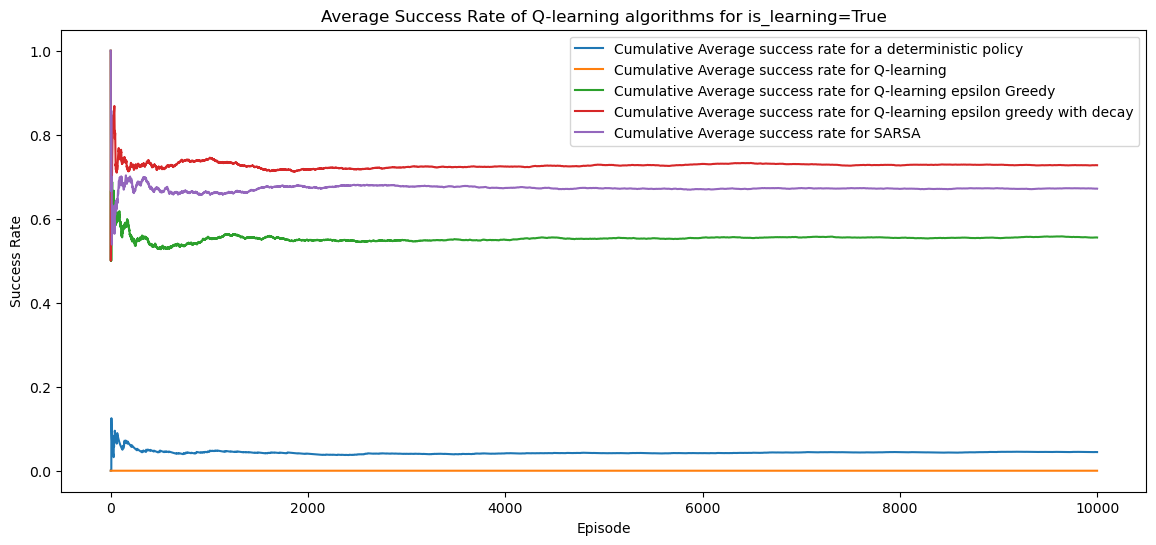

In [208]:
fig, axes = plt.subplots(figsize=(14, 6))
plt.plot(np.arange(len(rewards_d)), np.cumsum(rewards_d)/np.arange(len(rewards_d)), label="Cumulative Average success rate for a deterministic policy")
plt.plot(np.arange(len(rewards_q)), np.cumsum(rewards_q)/np.arange(len(rewards_q)), label="Cumulative Average success rate for Q-learning")
plt.plot(np.arange(len(rewards_q_greedy)), np.cumsum(rewards_q_greedy)/np.arange(len(rewards_q_greedy)), label="Cumulative Average success rate for Q-learning epsilon Greedy")
plt.plot(np.arange(len(rewards_q_greedy_decay)), np.cumsum(rewards_q_greedy_decay)/np.arange(len(rewards_q_greedy_decay)), label="Cumulative Average success rate for Q-learning epsilon greedy with decay")
plt.plot(np.arange(len(rewards_sarsa)), np.cumsum(rewards_sarsa)/np.arange(len(rewards_sarsa)), label="Cumulative Average success rate for SARSA")

axes.set(xlabel='Episode', ylabel='Success Rate', title='Average Success Rate of Q-learning algorithms for is_learning=True')
plt.legend()
plt.show()

## 3. Hyperparameter tuning

In [ ]:
# Qlearning optimization
alpha = [0.01, 0.05, 0.1, 0.5, 0.8, 0.9, 0.99]
gamma = [0.5, 0.8, 0.9, 0.95, 0.99, 1]
epsilon = [0.01, 0.05, 0.1, 0.5]

alphas=[]
success_rates = []
gammas=[]
epsilons=[]
rewards =[]
for al in alpha :
    for ga in gamma :
        for ep in epsilon :
            q_table = q_train_greedy_decay(env, alpha=al, gamma=ga, min_epsilon=ep)
            reward, success_rate, avg_nb_steps = agent_play(env, q_table)
            success_rates.append(success_rate)
            alphas.append(al)
            gammas.append(ga)
            epsilons.append(ep)
            rewards.append(reward)


In [141]:
df = pd.DataFrame()
df["alpha"]=alphas
df["gamma"]=gammas
df["epsilon"]=epsilons
df["success_rate"]=success_rates
df = df.sort_values(by="success_rate", ascending=False)
df

,alpha,gamma,epsilon,success_rate
67,0.10,0.99,0.50,0.828749
106,0.80,0.90,0.10,0.827628
42,0.05,0.99,0.10,0.826610
90,0.50,0.99,0.10,0.825203
136,0.90,0.99,0.01,0.824575
...,...,...,...,...
143,0.90,1.00,0.50,NaN
164,0.99,1.00,0.01,NaN
165,0.99,1.00,0.05,NaN
166,0.99,1.00,0.10,NaN


In [ ]:
fig, axes = plt.subplots(figsize=(14, 6))
title = f"Cummulative Average reward for Q-epsilon greedy decay for different parameters \n best success rate : {round(100*df.iloc[0]['success_rate'],2)} % \n best parameters : alpha = {df.iloc[0]['alpha']}, epsilon = {df.iloc[0]['epsilon']}, gamma = {df.iloc[0]['gamma']} "
plt.title(title)
for i in range(len(df)):
    plt.plot(np.arange(len(rewards[i])), np.cumsum(rewards[i])/np.arange(len(rewards[i])))
plt.legend()
plt.show()

![images/output0.png](images/output0.png)

In [147]:
q_table_greedy_decay = q_train_greedy_decay(env, alpha = 0.1, gamma = 0.99, min_epsilon=0.5)

Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:04<00:00, 2310.43it/s]

Finished Q-learning algorithm.
Average reward is : 0.0589


In [149]:
rewards_sarsa, success_rate_sarsa, avg_num_steps_sarsa= agent_play(env, q_table=q_table_greedy_decay, max_n_episodes=10000)


100%|██████████| 10000/10000 [00:06<00:00, 1440.51it/s]

Success rate is = 82.52643294379521 %
Average number of steps to succeed is = 38.38152476349471


In [ ]:
# SARSA optimization
alpha = [0.01, 0.05, 0.1, 0.5, 0.8, 0.9, 0.99]
gamma = [0.5, 0.8, 0.9, 0.95, 0.99, 1]
epsilon = [0.01, 0.05, 0.1, 0.5]
alphas=[]
success_rates = []
gammas=[]
epsilons=[]
rewards=[]
for al in alpha :
    for ga in gamma :
        for eps in epsilon :
            sarsa_table = sarsa_train(env, al, ga, eps, episodes = 10000, steps = 100)
            reward, success_rate, avg_nb_steps = agent_play(env, sarsa_table)
            success_rates.append(success_rate)
            alphas.append(al)
            gammas.append(ga)
            epsilons.append(eps)
            rewards.append(reward)


In [ ]:
df = pd.DataFrame()

df["epsilon"]=epsilons
df["alpha"]=alphas
df["gamma"]=gammas
df["success_rate"]=success_rates
df = df.sort_values(by="success_rate", ascending=False)
df

In [ ]:
fig, axes = plt.subplots(figsize=(14, 6))
title = f"Cummulative Average reward for SARSA for different parameters \n best success rate : {round(100*df.iloc[0]['success_rate'],2)} % \n best parameters : alpha = {df.iloc[0]['alpha']}, epsilon = {df.iloc[0]['epsilon']}, gamma = {df.iloc[0]['gamma']} "
plt.title(title)
for i in range(len(df)):
    plt.plot(np.arange(len(rewards[i])), np.cumsum(rewards[i])/np.arange(len(rewards[i])))
plt.legend()
plt.show()

![images/output.png](images/output.png)

In [168]:
sarsa_table = sarsa_train(env, alpha = 0.1, gamma = 0.99, epsilon = 0.1, episodes = 10000, steps = 100)

100%|██████████| 10000/10000 [00:04<00:00, 2094.41it/s]


In [169]:
rewards_sarsa, success_rate_sarsa, avg_num_steps_sarsa= agent_play(env, q_table=sarsa_table, max_n_episodes=10000)


100%|██████████| 10000/10000 [00:06<00:00, 1591.16it/s]

Success rate is = 77.58326216908625 %
Average number of steps to succeed is = 37.04707514944492


In all the past section, we've trained our algorithms in the slippery envirement with`is_slippery=False`. We will now establish a new frozen lake environment with `is_slippery=False`

In [210]:
env_no_slip = gym.make("FrozenLake-v1", is_slippery=False, render_mode=None)
np.random.seed(42)
observation, info = env.reset(seed=42)
num_actions = env.action_space.n
num_states = env.observation_space.n

Re-training for the new environment

In [211]:
q_table = q_train(env_no_slip)
q_table_greedy = q_train_greedy(env_no_slip)
q_table_greedy_decay=q_train_greedy_decay(env_no_slip, alpha = 0.1, gamma = 0.99, min_epsilon=0.5)
sarsa_table = sarsa_train(env_no_slip)


Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:35<00:00, 278.16it/s]


Finished Q-learning algorithm.
Average reward is : 0.0
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:23<00:00, 431.20it/s]


Finished Q-learning algorithm.
Average reward is : 0.0
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:03<00:00, 3186.06it/s]


Finished Q-learning algorithm.
Average reward is : 0.3448


100%|██████████| 10000/10000 [00:17<00:00, 580.26it/s]


Re-calculating the performance 

In [219]:
rewards_d, success_rate_d, avg_num_steps_d= agent_play(env_no_slip, q_table=deterministic_q_table)
rewards_q, success_rate_q, avg_num_steps_q= agent_play(env_no_slip, q_table=q_table)
rewards_q_greedy, success_rate_q_greedy, avg_num_steps_q_greedy= agent_play(env_no_slip, q_table=q_table_greedy)
rewards_q_greedy_decay, success_rate_q_greedy_decay, avg_num_steps_q_greedy_decay= agent_play(env_no_slip, q_table=q_table_greedy_decay)
rewards_sarsa, success_rate_sarsa, avg_num_steps_sarsa= agent_play(env_no_slip, q_table=sarsa_table)

100%|██████████| 10000/10000 [00:01<00:00, 9466.49it/s]


Success rate is = 100.0 %
Average number of steps to succeed is = 6.0


100%|██████████| 10000/10000 [00:15<00:00, 658.85it/s]


Success rate is = 0.0 %
Average number of steps to succeed is = 100.0


100%|██████████| 10000/10000 [00:22<00:00, 435.03it/s]


Success rate is = 0.0 %
Average number of steps to succeed is = 100.0


100%|██████████| 10000/10000 [00:01<00:00, 6437.19it/s]


Success rate is = 100.0 %
Average number of steps to succeed is = 6.0


100%|██████████| 10000/10000 [00:23<00:00, 431.47it/s]

Success rate is = 0.0 %
Average number of steps to succeed is = 100.0


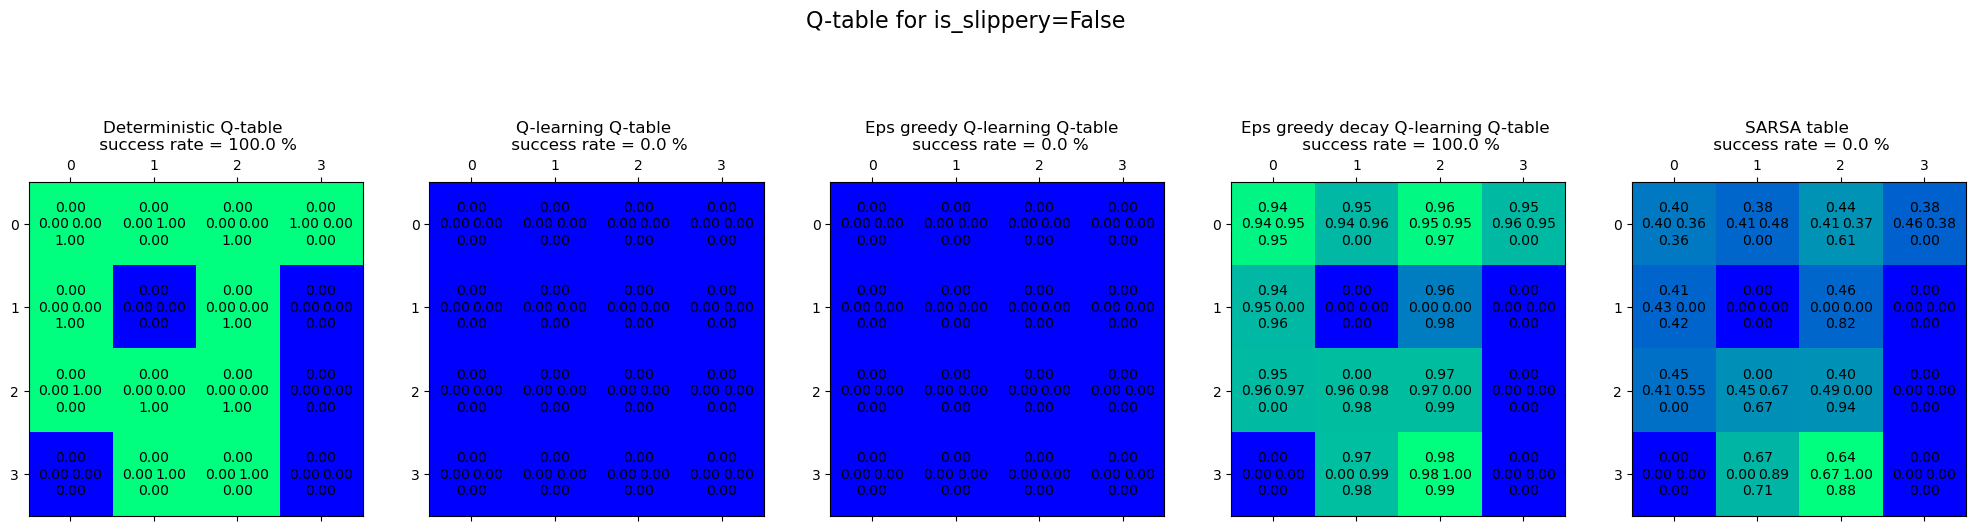

In [222]:
deterministic_q_table = np.load("data/deterministic_q_table.npy")

fig, ax = plt.subplots(1, 5)
fig.suptitle("Q-table for is_slippery=False", fontsize=16)

fig.set_size_inches(25, 7)
# im = Image.open('images/frozen_lake.jpg')
plt.title("Q-table of the game")

# Creating the heat maps
map_q = np.sum(q_table, axis = 1)
map_q= map_q.reshape(4, 4)

map_d = np.sum(deterministic_q_table, axis = 1)
map_d= map_d.reshape(4, 4)

map_g = np.sum(q_table_greedy, axis = 1)
map_g= map_g.reshape(4, 4)

map_e = np.sum(q_table_greedy_decay, axis = 1)
map_e= map_e.reshape(4, 4)

map_s = np.sum(sarsa_table, axis = 1)
map_s= map_s.reshape(4, 4)


# ax[0].imshow(im, alpha=1)
# ax[1].imshow(im, alpha=1)

ax[0].matshow(map_d, cmap='winter')
ax[1].matshow(map_q, cmap='winter')
ax[2].matshow(map_g, cmap='winter')
ax[3].matshow(map_e, cmap='winter')
ax[4].matshow(map_s, cmap='winter')

pos=[0,1,2,3]

deterministic_q_table_reshaped=deterministic_q_table.reshape((4,4,4))
q_table_reshaped=q_table.reshape((4,4,4))
greedy_reshaped=q_table_greedy.reshape((4,4,4))
q_table_greedy_decay_reshaped =q_table_greedy_decay.reshape((4,4,4))
sarsa_reshaped =sarsa_table.reshape((4,4,4))


deviation = 0.2
for i in pos: # rows
    for j in pos: # cols

        ax[0].text(j-deviation, i, '{:0.2f}'.format(deterministic_q_table_reshaped[i][j][0]), ha='center', va='center') # 0 Left
        ax[0].text(j, i+deviation, '{:0.2f}'.format(deterministic_q_table_reshaped[i][j][1]), ha='center', va='center') # 1 Down
        ax[0].text(j+deviation, i, '{:0.2f}'.format(deterministic_q_table_reshaped[i][j][2]), ha='center', va='center') # 2 right
        ax[0].text(j, i-deviation, '{:0.2f}'.format(deterministic_q_table_reshaped[i][j][3]), ha='center', va='center') # 3 up
        ax[0].set_title(f"Deterministic Q-table \n success rate = {100*round(success_rate_d,2)} %")

        ax[1].text(j-deviation, i, '{:0.2f}'.format(q_table_reshaped[i][j][0]), ha='center', va='center') # 0 Left
        ax[1].text(j, i+deviation, '{:0.2f}'.format(q_table_reshaped[i][j][1]), ha='center', va='center') # 1 Down
        ax[1].text(j+deviation, i, '{:0.2f}'.format(q_table_reshaped[i][j][2]), ha='center', va='center') # 2 right
        ax[1].text(j, i-deviation, '{:0.2f}'.format(q_table_reshaped[i][j][3]), ha='center', va='center') # 3 up
        ax[1].set_title(f"Q-learning Q-table \n success rate = {100*round(success_rate_q,2)} %")

        ax[2].text(j-deviation, i, '{:0.2f}'.format(greedy_reshaped[i][j][0]), ha='center', va='center') # 0 Left
        ax[2].text(j, i+deviation, '{:0.2f}'.format(greedy_reshaped[i][j][1]), ha='center', va='center') # 1 Down
        ax[2].text(j+deviation, i, '{:0.2f}'.format(greedy_reshaped[i][j][2]), ha='center', va='center') # 2 right
        ax[2].text(j, i-deviation, '{:0.2f}'.format(greedy_reshaped[i][j][3]), ha='center', va='center') # 3 up
        ax[2].set_title(f"Eps greedy Q-learning Q-table  \n success rate = {100*round(success_rate_q_greedy,2)} %")


        ax[3].text(j-deviation, i, '{:0.2f}'.format(q_table_greedy_decay_reshaped[i][j][0]), ha='center', va='center') # 0 Left
        ax[3].text(j, i+deviation, '{:0.2f}'.format(q_table_greedy_decay_reshaped[i][j][1]), ha='center', va='center') # 1 Down
        ax[3].text(j+deviation, i, '{:0.2f}'.format(q_table_greedy_decay_reshaped[i][j][2]), ha='center', va='center') # 2 right
        ax[3].text(j, i-deviation, '{:0.2f}'.format(q_table_greedy_decay_reshaped[i][j][3]), ha='center', va='center') # 3 up
        ax[3].set_title(f"Eps greedy decay Q-learning Q-table \n success rate = {100*round(success_rate_q_greedy_decay,2)} %")

        ax[4].text(j-deviation, i, '{:0.2f}'.format(sarsa_reshaped[i][j][0]), ha='center', va='center') # 0 Left
        ax[4].text(j, i+deviation, '{:0.2f}'.format(sarsa_reshaped[i][j][1]), ha='center', va='center') # 1 Down
        ax[4].text(j+deviation, i, '{:0.2f}'.format(sarsa_reshaped[i][j][2]), ha='center', va='center') # 2 right
        ax[4].text(j, i-deviation, '{:0.2f}'.format(sarsa_reshaped[i][j][3]), ha='center', va='center') # 3 up
        ax[4].set_title(f"SARSA table \n success rate = {100*round(success_rate_sarsa,2)} %")
plt.show()

/tmp/ipykernel_57852/3416567757.py:2: RuntimeWarning: divide by zero encountered in divide
  plt.plot(np.arange(len(rewards_d)), np.cumsum(rewards_d)/np.arange(len(rewards_d)), label="Cumulative Average success rate for a deterministic policy")
/tmp/ipykernel_57852/3416567757.py:3: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.arange(len(rewards_q)), np.cumsum(rewards_q)/np.arange(len(rewards_q)), label="Cumulative Average success rate for Q-learning")
/tmp/ipykernel_57852/3416567757.py:4: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.arange(len(rewards_q_greedy)), np.cumsum(rewards_q_greedy)/np.arange(len(rewards_q_greedy)), label="Cumulative Average success rate for Q-learning epsilon Greedy")
/tmp/ipykernel_57852/3416567757.py:5: RuntimeWarning: divide by zero encountered in divide
  plt.plot(np.arange(len(rewards_q_greedy_decay)), np.cumsum(rewards_q_greedy_decay)/np.arange(len(rewards_q_greedy_decay)), label="Cumulative Average success rate 

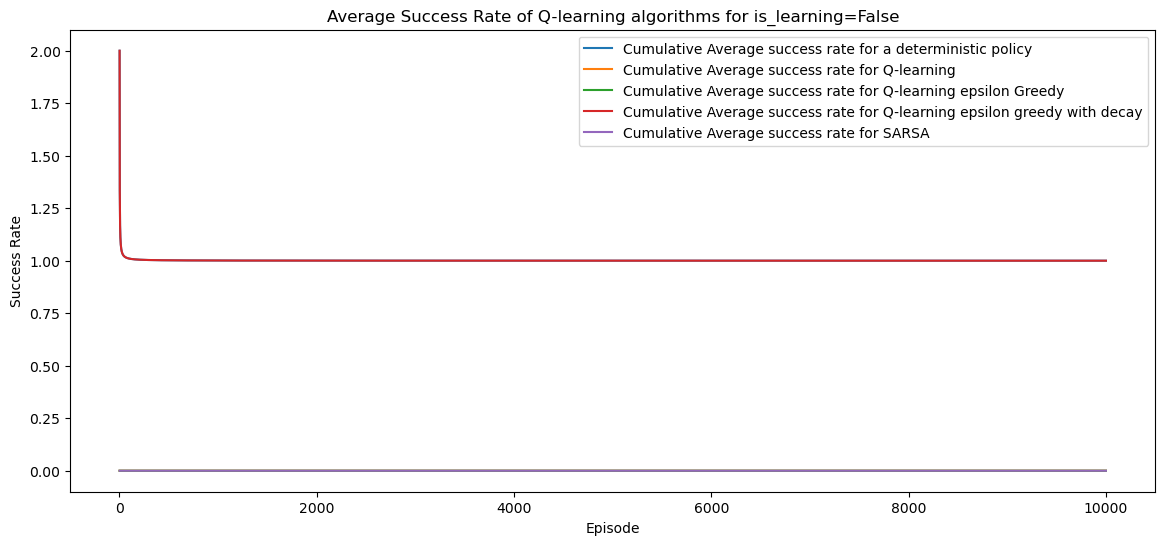

In [223]:
fig, axes = plt.subplots(figsize=(14, 6))
plt.plot(np.arange(len(rewards_d)), np.cumsum(rewards_d)/np.arange(len(rewards_d)), label="Cumulative Average success rate for a deterministic policy")
plt.plot(np.arange(len(rewards_q)), np.cumsum(rewards_q)/np.arange(len(rewards_q)), label="Cumulative Average success rate for Q-learning")
plt.plot(np.arange(len(rewards_q_greedy)), np.cumsum(rewards_q_greedy)/np.arange(len(rewards_q_greedy)), label="Cumulative Average success rate for Q-learning epsilon Greedy")
plt.plot(np.arange(len(rewards_q_greedy_decay)), np.cumsum(rewards_q_greedy_decay)/np.arange(len(rewards_q_greedy_decay)), label="Cumulative Average success rate for Q-learning epsilon greedy with decay")
plt.plot(np.arange(len(rewards_sarsa)), np.cumsum(rewards_sarsa)/np.arange(len(rewards_sarsa)), label="Cumulative Average success rate for SARSA")

axes.set(xlabel='Episode', ylabel='Success Rate', title='Average Success Rate of Q-learning algorithms for is_learning=False')
plt.legend()
plt.show()

## 3. Conclusion :
We've established 3 variations of the Q-learning algorithm. As well as the SARSA algorithm, we've benchmarked their performance for both `slippery` and `non-slippery` environments. Furthermore, we've optimized their performance through a manual grid search of the hyperparameters.